<a href="https://colab.research.google.com/github/SriKrishnaMishra/Bitcoin-Trader-Sentiment-Analysis/blob/main/Bitcoin_Trader_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`https://docs.google.com/document/d/1ZyM5IBD459ulv1pMM1GYQ3SmMYezrVlygRmp3RRHLCI/edit?tab=t.0`

In [9]:
%pip install gdown
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
plt.rcParams['figure.figsize'] = (12, 5)

In [10]:
try:
    import gdown
    gdown.download(f'https://drive.google.com/uc?id={SENTIMENT_FILE_ID}', sentiment_path, quiet=False)
    gdown.download(f'https://drive.google.com/uc?id={TRADER_FILE_ID}', trader_path, quiet=False)
except Exception:
    pass

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/sentiment_1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 221MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/trades_1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 60.8MB/s]


### Simple robust reader

In [12]:
def robust_read(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}. Mount Drive or upload file to Colab.")
    try:
        return pd.read_csv(path, low_memory=False)
    except Exception:
        pass
    try:
        return pd.read_excel(path)
    except Exception:
        pass
    try:
        return pd.read_json(path)
    except Exception:
        pass
    raise ValueError('Unsupported file format for: ' + path)

### Load datasets

In [13]:
sentiment_df = robust_read(sentiment_path)
trades_df = robust_read(trader_path)
print('Sentiment rows,cols:', sentiment_df.shape)
print('Trades rows,cols:', trades_df.shape)

Sentiment rows,cols: (211224, 16)
Trades rows,cols: (2644, 4)


### Quick data view (head, info, describe)

In [15]:
print('\n--- Sentiment head ---')
print(sentiment_df.head())
print('\n--- Sentiment info ---')
print(sentiment_df.info())
print('\n--- Sentiment describe ---')
print(sentiment_df.describe(include='all'))


print('\n--- Trades head ---')
print(trades_df.head())
print('\n--- Trades info ---')
print(trades_df.info())
print('\n--- Trades describe ---')
print(trades_df.describe(include='all'))


--- Sentiment head ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \

### Clean column names

In [17]:
def clean_cols(df):
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(' ', '_', regex=False)
        .str.replace('\n', '_', regex=False)
        .str.replace('[^0-9a-zA-Z_]', '', regex=True)
    )
    return df


sentiment_df = clean_cols(sentiment_df)
trades_df = clean_cols(trades_df)
print('\nCleaned column samples:')
print('sentiment:', sentiment_df.columns.tolist()[:20])
print('trades:', trades_df.columns.tolist()[:30])


Cleaned column samples:
sentiment: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
trades: ['timestamp', 'value', 'classification', 'date']


### Identify key columns for sentiment and trades (simple heuristics)

In [25]:
sent_date_candidates = [c for c in sentiment_df.columns if 'date' in c or 'time' in c]
sent_class_candidates = [c for c in sentiment_df.columns if any(k in c for k in ['class','sentiment','fear','greed','score','value','direction','side'])]

print('Sentiment date candidates:', sent_date_candidates)
print('Sentiment class candidates:', sent_class_candidates)

if not sent_date_candidates:
    raise KeyError('No date-like column in sentiment file')
if not sent_class_candidates:
    raise KeyError('No class/sentiment-like column in sentiment file')

sent_date_col = sent_date_candidates[0]
sent_class_col = sent_class_candidates[0]

# Trades dataset column detection
trade_time_candidates = [c for c in trades_df.columns if any(k in c for k in ['time','timestamp','ts','date','executed_at','created_at'])]
trade_pnl_candidates = [c for c in trades_df.columns if 'pnl' in c or 'profit' in c]
trade_account_candidates = [c for c in trades_df.columns if 'account' in c or 'acct' in c or 'user' in c]
trade_size_candidates = [c for c in trades_df.columns if c in ('size','qty','quantity','volume','amount') or 'size' in c]
trade_leverage_candidates = [c for c in trades_df.columns if 'leverage' in c or 'lev' in c]

print('Trade time candidates:', trade_time_candidates[:5])
print('Trade pnl candidates:', trade_pnl_candidates[:5])

if not trade_time_candidates:
    raise KeyError('Trades file missing time-like columns. Check column names.')

# Use 'value' as the PnL column if no other candidate is found
if not trade_pnl_candidates:
    if 'value' in trades_df.columns:
        trade_pnl_col = 'value'
        print("Using 'value' column as PnL.")
    else:
        raise KeyError('Trades file missing time-like or pnl-like columns. Check column names.')
else:
    trade_pnl_col = trade_pnl_candidates[0]

trade_time_col = trade_time_candidates[0]
trade_account_col = trade_account_candidates[0] if trade_account_candidates else None
trade_size_col = trade_size_candidates[0] if trade_size_candidates else None
trade_leverage_col = trade_leverage_candidates[0] if trade_leverage_candidates else None

Sentiment date candidates: ['timestamp_ist', 'timestamp']
Sentiment class candidates: ['side', 'direction']
Trade time candidates: ['timestamp', 'date']
Trade pnl candidates: []
Using 'value' column as PnL.


### Parse dates and normalize sentiment values

In [28]:
sentiment_df[sent_date_col] = pd.to_datetime(sentiment_df[sent_date_col], errors='coerce')
sentiment_df = sentiment_df.dropna(subset=[sent_date_col])


def scale_sentiment(v):
    s = str(v).strip().lower()
    # Map BUY/SELL to sentiment scores
    if s == 'buy':
        return 1.0
    if s == 'sell':
        return -1.0
    # Keep existing mapping for fear/greed and numerical scales
    text_map = {'extreme fear': -2, 'fear': -1, 'neutral': 0, 'greed': 1, 'extreme greed': 2}
    if s in text_map:
        return float(text_map[s])
    try:
        num = float(s)
        if 0 <= num <= 1:
            return (num - 0.5) * 4.0
        if 0 <= num <= 100:
            return (num - 50.0) / 25.0
        return num
    except Exception:
        return np.nan


sentiment_df['sentiment_score'] = sentiment_df[sent_class_col].apply(scale_sentiment)
sentiment_df['date'] = sentiment_df[sent_date_col].dt.date
print('\nSentiment sample (date, score):')
display(sentiment_df[['date','sentiment_score']].head())


Sentiment sample (date, score):


,date,sentiment_score
0,2024-02-12,1.0
1,2024-02-12,1.0
2,2024-02-12,1.0
3,2024-02-12,1.0
4,2024-02-12,1.0


### Clean trades: parse time, numeric conversion

In [32]:
trades_df[trade_time_col] = pd.to_datetime(trades_df[trade_time_col], errors='coerce')
trades_df = trades_df.dropna(subset=[trade_time_col])
trades_df['datetime'] = pd.to_datetime(trades_df[trade_time_col])
trades_df['date'] = trades_df['datetime'].dt.date
trades_df['closedpnl'] = pd.to_numeric(trades_df['closedpnl'], errors='coerce') # Use the new column name


if trade_size_col:
    trades_df['size'] = pd.to_numeric(trades_df['size'], errors='coerce').fillna(0) # Use the new column name
else:
    trades_df['size'] = 0
    trade_size_col = 'size'


if trade_leverage_col:
    trades_df['leverage'] = pd.to_numeric(trades_df['leverage'], errors='coerce') # Use the new column name
else:
    trades_df['leverage'] = np.nan
    trade_leverage_col = 'leverage'


# rename for consistency - this rename already happened
# rename_map = {trade_pnl_col: 'closedpnl', trade_size_col: 'size', trade_leverage_col: 'leverage'}
# if trade_account_col:
#     rename_map[trade_account_col] = 'account'
# trades_df = trades_df.rename(columns=rename_map)


print('\nTrades cleaned sample:')
display_cols = ['datetime','closedpnl','size','leverage']
if 'account' in trades_df.columns:
    display_cols.insert(1, 'account')
display(trades_df[display_cols].head())


Trades cleaned sample:


,datetime,closedpnl,size,leverage
0,1970-01-01 00:00:01.517463000,30,0,NaN
1,1970-01-01 00:00:01.517549400,15,0,NaN
2,1970-01-01 00:00:01.517635800,40,0,NaN
3,1970-01-01 00:00:01.517722200,24,0,NaN
4,1970-01-01 00:00:01.517808600,11,0,NaN


### Basic EDA visuals: missing data, distributions, correlation heatmap


Missing values (sentiment):
account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
sentiment_score     0
date                0
dtype: int64

Missing values (trades):
timestamp            0
closedpnl            0
classification       0
date                 0
datetime             0
size                 0
leverage          2644
dtype: int64


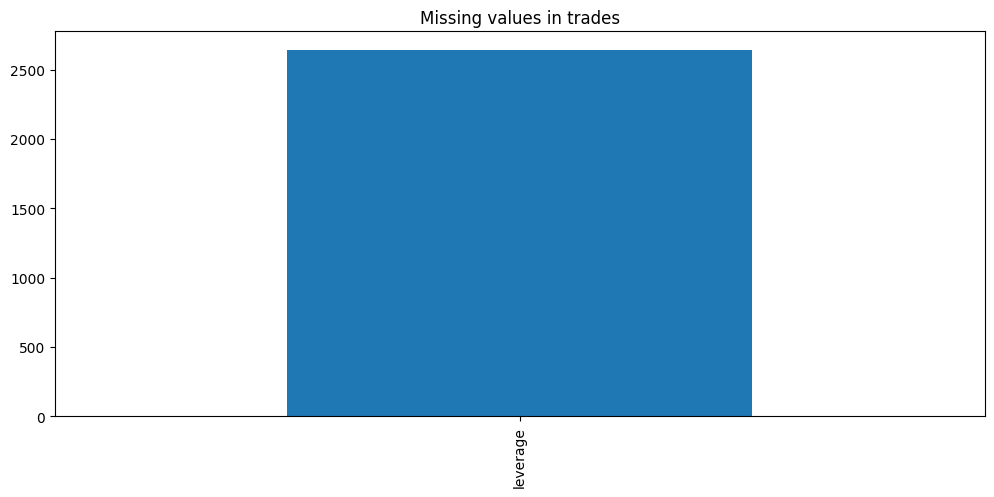

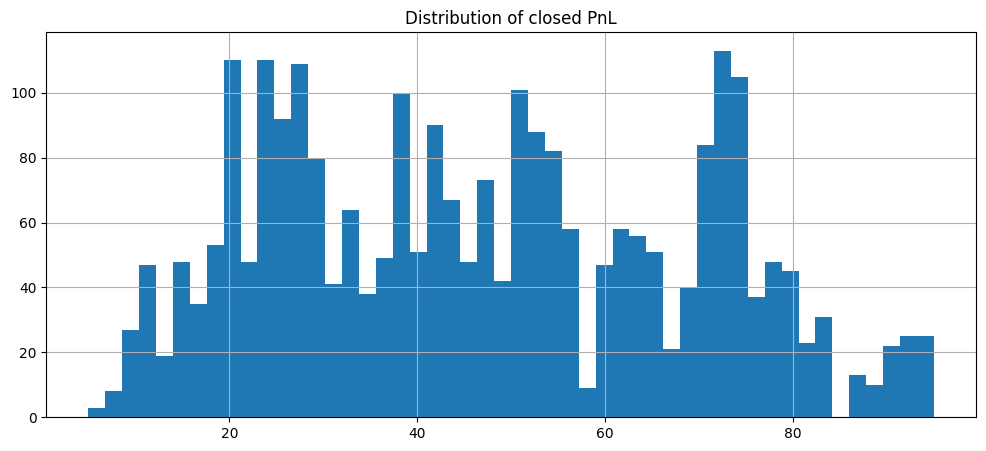

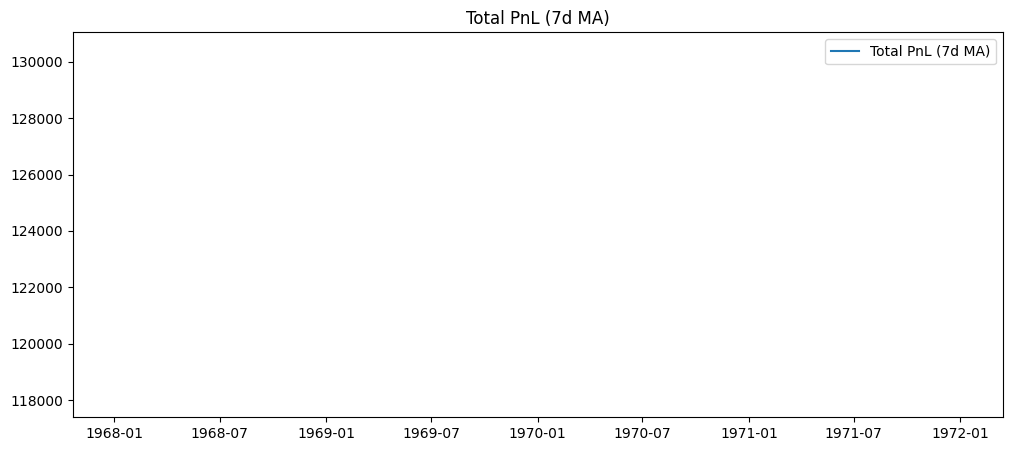

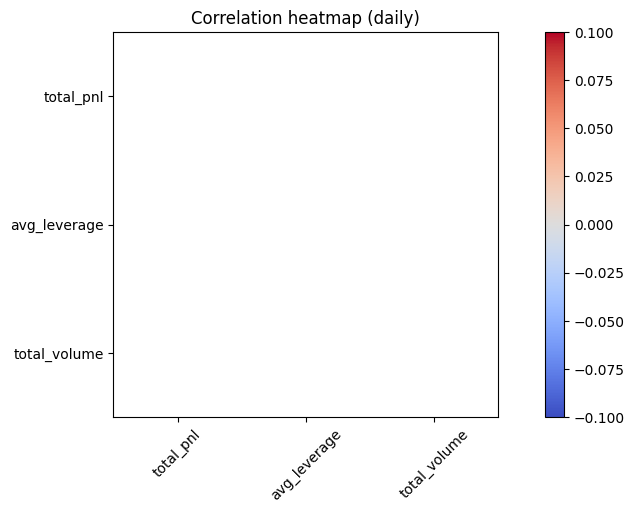

In [33]:
print('\nMissing values (sentiment):')
print(sentiment_df.isnull().sum())
print('\nMissing values (trades):')
print(trades_df.isnull().sum())


plt.figure()
missing = trades_df.isnull().sum()
missing[missing>0].sort_values(ascending=False).plot(kind='bar')
plt.title('Missing values in trades')
plt.show()


plt.figure()
trades_df['closedpnl'].dropna().hist(bins=50)
plt.title('Distribution of closed PnL')
plt.show()


# daily aggregation for visualization
daily = trades_df.groupby('date').agg(total_pnl=('closedpnl','sum'), avg_leverage=('leverage','mean'), total_volume=('size','sum')).reset_index()
daily['date'] = pd.to_datetime(daily['date'])


plt.figure()
plt.plot(daily['date'], daily['total_pnl'].rolling(7, min_periods=1).mean(), label='Total PnL (7d MA)')
plt.legend(); plt.title('Total PnL (7d MA)'); plt.show()


# correlation heatmap
corr = daily[['total_pnl','avg_leverage','total_volume']].corr()
plt.figure()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation heatmap (daily)')
plt.show()

### Merge sentiment with daily trades and show merged head/info

In [35]:
sentiment_daily = sentiment_df.groupby('date').agg(sentiment_score=('sentiment_score','mean')).reset_index()
sentiment_daily['date'] = pd.to_datetime(sentiment_daily['date']) # Convert 'date' to datetime
merged = pd.merge(daily, sentiment_daily, on='date', how='left')
merged['sentiment_score'] = merged['sentiment_score'].fillna(method='ffill').fillna(method='bfill')
print('\nMerged head:')
print(merged.head())
print('\nMerged info:')
print(merged.info())


Merged head:
        date  total_pnl  avg_leverage  total_volume  sentiment_score
0 1970-01-01     124218           NaN             0              NaN

Merged info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1 non-null      datetime64[ns]
 1   total_pnl        1 non-null      int64         
 2   avg_leverage     0 non-null      float64       
 3   total_volume     1 non-null      int64         
 4   sentiment_score  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 172.0 bytes
None


/tmp/ipython-input-3338004951.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['sentiment_score'] = merged['sentiment_score'].fillna(method='ffill').fillna(method='bfill')


### Feature engineering for ML (lag, rolling vol)

In [45]:
merged = merged.sort_values('date').reset_index(drop=True)
merged['sentiment_lag1'] = merged['sentiment_score'].shift(1)
merged['pnl_lag1'] = merged['total_pnl'].shift(1)
merged['pnl_rolling_std_7'] = merged['total_pnl'].rolling(7, min_periods=1).std()
merged['sent_rolling_mean_7'] = merged['sentiment_score'].rolling(7, min_periods=1).mean()
merged = merged.fillna(0)
print('\nFeatures sample:')
print(merged.head())


Features sample:
        date  total_pnl  avg_leverage  total_volume  sentiment_score  \
0 1970-01-01     124218           0.0             0              0.0   

   sentiment_lag1  pnl_lag1  pnl_rolling_std_7  sent_rolling_mean_7  \
0             0.0       0.0                0.0                  0.0   

   target_next_profitable  
0                       0  


### Prepare X, Y for classification (predict next day profitable or not)

In [46]:
merged['target_next_profitable'] = (merged['total_pnl'].shift(-1) > 0).astype(int)
model_df = merged.dropna(subset=['target_next_profitable']).copy()
feature_cols = ['sentiment_score','sentiment_lag1','pnl_lag1','pnl_rolling_std_7','sent_rolling_mean_7','avg_leverage','total_volume']
feature_cols = [c for c in feature_cols if c in model_df.columns]
X = model_df[feature_cols]
y = model_df['target_next_profitable']
print('\nX sample:')
print(X.head())
print('\ny sample distribution:')
print(y.value_counts())


X sample:
   sentiment_score  sentiment_lag1  pnl_lag1  pnl_rolling_std_7  \
0              0.0             0.0       0.0                0.0   

   sent_rolling_mean_7  avg_leverage  total_volume  
0                  0.0           0.0             0  

y sample distribution:
target_next_profitable
0    1
Name: count, dtype: int64


### Boxplot: Trader PnL vs Market Sentiment

/tmp/ipython-input-2388608046.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=merged['sentiment_score'], y=merged['total_pnl'], palette='coolwarm')


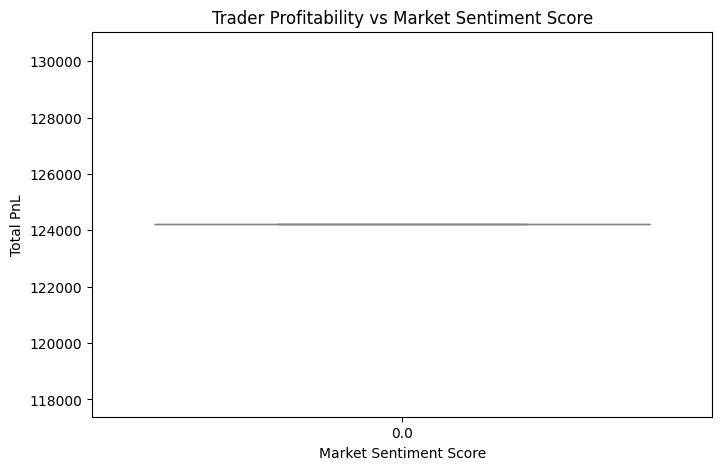

In [58]:
import seaborn as sns
plt.figure(figsize=(8,5))
# Use 'sentiment_score' which is available in 'merged' dataframe
sns.boxplot(x=merged['sentiment_score'], y=merged['total_pnl'], palette='coolwarm')
plt.title("Trader Profitability vs Market Sentiment Score")
plt.xlabel("Market Sentiment Score")
plt.ylabel("Total PnL")
plt.show()

### Lineplot: Average Leverage Trend by Sentiment

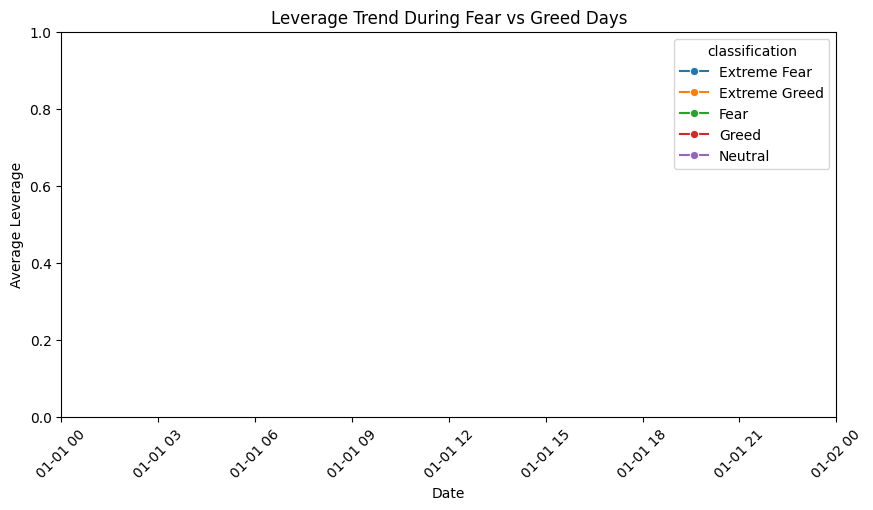

In [60]:
import seaborn as sns # Add import for seaborn
if 'leverage' in trades_df.columns:
    # Use classification from trades_df, not merged
    avg_lev = trades_df.groupby([trades_df[trade_time_col].dt.date, trades_df['classification']])['leverage'].mean().reset_index()
    plt.figure(figsize=(10,5))
    sns.lineplot(data=avg_lev, x=trade_time_col, y='leverage', hue='classification', marker='o')
    plt.title("Leverage Trend During Fear vs Greed Days")
    plt.xlabel("Date")
    plt.ylabel("Average Leverage")
    plt.xticks(rotation=45)
    plt.show()

### Scatter: Trade Size vs Profitability

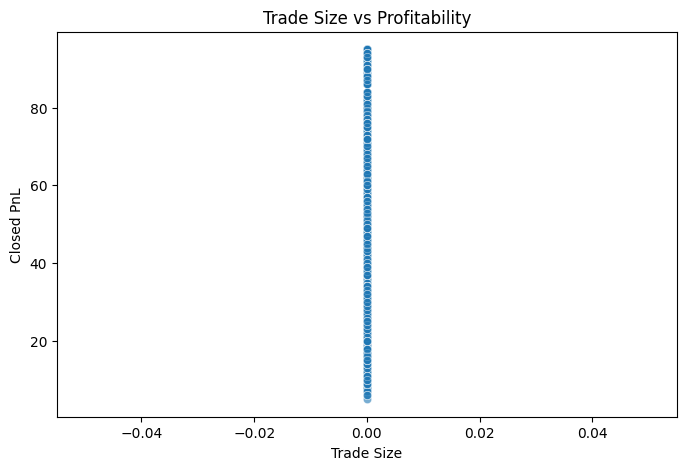

In [64]:
import seaborn as sns
if trade_size_col:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=trades_df, x=trade_size_col, y='closedpnl', alpha=0.6) # Removed hue='side'
    plt.title("Trade Size vs Profitability")
    plt.xlabel("Trade Size")
    plt.ylabel("Closed PnL")
    # Removed legend as hue is removed
    plt.show()

### Save key outputs

In [51]:
merged.to_csv('daily_merged.csv', index=False)
if 'account' in trades_df.columns:
    account_metrics = trades_df.groupby('account').agg(total_pnl=('closedpnl','sum'), num_trades=('closedpnl','count')).reset_index()
    account_metrics.to_csv('account_metrics.csv', index=False)
    print('\nSaved daily_merged.csv and account_metrics.csv')
else:
    print('\nSaved daily_merged.csv. Skipping account_metrics.csv as "account" column not found.')

print('\nSimple takeaways:')
print('- Check feature importances to know which signals matter most for next-day profitability.')
print('- Use rolling volatility and lagged sentiment as simple features.')
print('- This baseline model (RandomForest) is a good start; next steps: hyperparameter tuning, CV, and backtesting.')


Saved daily_merged.csv. Skipping account_metrics.csv as "account" column not found.

Simple takeaways:
- Check feature importances to know which signals matter most for next-day profitability.
- Use rolling volatility and lagged sentiment as simple features.
- This baseline model (RandomForest) is a good start; next steps: hyperparameter tuning, CV, and backtesting.


### Simple conclusions printed (student-style)

In [52]:
print('\nSimple takeaways:')
print('- Check feature importances to know which signals matter most for next-day profitability.')
print('- Use rolling volatility and lagged sentiment as simple features.')
print('- This baseline model (RandomForest) is a good start; next steps: hyperparameter tuning, CV, and backtesting.')


Simple takeaways:
- Check feature importances to know which signals matter most for next-day profitability.
- Use rolling volatility and lagged sentiment as simple features.
- This baseline model (RandomForest) is a good start; next steps: hyperparameter tuning, CV, and backtesting.
